In [1]:
# Examine wind case results
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import cmocean
import utide
import os, sys
# sys.path.append(os.path.abspath('../TEF'))
# import TEF_Variables as tef
import Functions as fun
#sys.path.append(os.path.abspath('/work/oceans/wbao/MITgcm_results/jorgemontt'))

/opt/miniconda3/envs/pyenv/lib/python3.10/site-packages/utide/harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
/opt/miniconda3/envs/pyenv/lib/python3.10/site-packages/utide/harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [2]:
#path1 = '/work/oceans/wbao/MITgcm_results/jorgemontt/Qsg150_wind'
path1 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_wind/'
path2 = '/Volumes/T7 Shield/MITgcm_jorgemontt/Qsg150_rep_wind/'

taum1 = np.array([-0.2, -0.1, 0, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8, -1.5, 1.5]) # maximum wind stress (single event)
taum2 = np.array([-0.2, -0.1, 0.1, 0.2, -0.3, -0.4, 0.3, 0.4, -0.8, 0.8]) # maximum wind stress (repeated events)

xrange = np.array([0,97]) # X index range for the segment between glacier and outer sill
xsill = 95

# Indexes for down-/up-fjord wind
down_case1 = [3,4,5,8,9,11,13]
up_case1 = [2,1,6,7,10,12]

down_case2 = [3,4,7,8,10]
up_case2 = [2,1,5,6,9]

## Wind Forcing

In [3]:
# Zonal Wind Stress
externForcingCircle = 30*86400 # Forcing period in second
externForcingPeriod = 0.25*86400 # time interval between forcing field records
nt = int(externForcingCircle / externForcingPeriod)
model_time = np.linspace(0,externForcingCircle,nt+1);
up = 0*86400 / externForcingPeriod
down = 2.5*86400 / externForcingPeriod
ramp = 0.5*86400 / externForcingPeriod
taum = taum1.copy() # maximum wind stress

zonal_wind_stress = np.zeros((len(taum),nt))

nf = int(down+ramp)
forcing = np.zeros((len(taum),nf))

for i in range(0,len(taum)):
    tau = taum[i]
    for j in range(nf):
        if j <= up - 1:
            forcing[i, j] = 0
        elif j < up + ramp - 1:
            forcing[i, j] = tau * (j - (up - 1)) / ramp
        elif j > down-1:
            forcing[i, j] = tau * (down + ramp - 1 - j) / ramp
        else:
            forcing[i, j] = tau

zonal_wind_stress[:,:nf] = forcing

rt = 1 # number of repeated wind events

zonal_wind_stress[:,:nf*rt] = np.tile(forcing, rt)

wind = np.concatenate((np.zeros((len(taum),1)), zonal_wind_stress), axis=1)

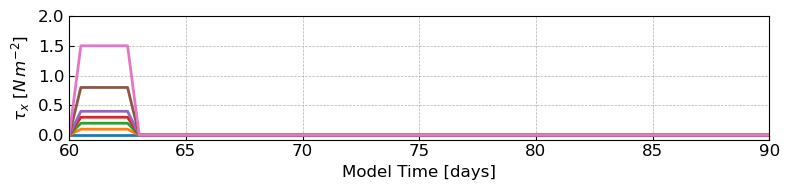

In [8]:
# Plot zonal wind stress
fig0 = plt.figure(figsize=(8,2), tight_layout=True)

ax = fig0.add_subplot(111)
plt.grid(linestyle = '--', linewidth = 0.5)

# for i in range(len(taum)):
#     ax.plot(model_time/86400,wind[i,:],lw=2,label=str(taum[i]))

for i in down_case1:
    ax.plot(model_time/86400+60,wind[i-1,:],lw=2,label=str(taum[i-1]))
#
#ax.legend(title=r'',loc='best',fontsize=12)
ax.set_xlim([60, 90])
#ax.set_ylim([-.25, .25])
ax.set_yticks([0,.5,1,1.5,2])
ax.set_xlabel(r'Model Time [days]', size=12)
ax.set_ylabel(r'$\tau_x$ [$N\,m^{-2}$]',fontsize=12)
ax.tick_params(direction='in', labelsize=12)

## Volume Temperature

In [ ]:
# Calculate Volume Temperature
Tv1 = []
for i in up_case1:
    vTemp1, model_time = fun.vol_temp(path1,i,xrange)
    Tv1.append(vTemp1)


Tv2 = []
for j in up_case2:
    vTemp2, model_time = vol_temp(path2,j,xrange)
    Tv2.append(vTemp2)

In [ ]:
day = model_time / 86400 # days

fig0 = plt.figure(figsize=(10,4), tight_layout=True)    
ax1 = fig0.add_subplot(111)

dt = 3600 # time interval of 0.5 day
plt.grid(linestyle = '--', linewidth = 0.5)

ax1.plot(day[1:],24*np.diff(fun.filt_godin(Tv1[0])),lw=2,label=r'-0.1')
ax1.plot(day[1:],24*np.diff(fun.filt_godin(Tv1[1])),lw=2,label=r'-0.2')
# ax1.plot(day[1:],24*np.diff(filt_godin(Tv1[2])),lw=2,label=r'-0.3')
# ax1.plot(day[1:],24*np.diff(filt_godin(Tv1[3])),lw=2,label=r'-0.4')
# ax1.plot(day[1:],24*np.diff(filt_godin(Tv1[0])),lw=2,label=r'0')
# ax1.plot(day[1:],24*np.diff(filt_godin(Tv2[0])),lw=2,label=r'-0.1')
# ax1.plot(day[1:],24*np.diff(filt_godin(Tv2[1])),lw=2,label=r'-0.2')
# ax1.plot(day[1:],24*np.diff(filt_godin(Tv2[2])),lw=2,label=r'-0.3')
# ax1.plot(day[1:],24*np.diff(filt_godin(Tv2[3])),lw=2,label=r'-0.4')
ax1.axhline(y=0, color='k',linestyle='--', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='upper right',fontsize=12)

ax1.set(xlim=(60, 90), ylim=(-0.15, 0.15))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$\frac{dT_v}{dt}$ [$^\circ C\;d^{-1}$]',fontsize=12)

#fig_path ="/home/1959/Jupyter_Figs/FjordModeling/JorgeMontt/"
fig_path ="/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/"
#fig0.savefig(fig_path + 'volTemp_up-wind_rep.png', dpi=300, bbox_inches='tight')

## TEF

In [ ]:
Qin1 = []
Qout1 = []
Sin1 = []
Sout1 = []
xsill = 95 # index for outer sill

for i in up_case1:    
    qin, qout, sin, sout = fun.tef_transport(path1,i,xsill)
   
    Qin1.append(qin)
    Qout1.append(qout)
    Sin1.append(sin)
    Sout1.append(sout)


In [ ]:
Qin2 = []
Qout2 = []
Sin2 = []
Sout2 = []

for i in up_case2:    
    qin, qout, sin, sout = tef_transport(path2,i,xsill)
   
    Qin2.append(qin)
    Qout2.append(qout)
    Sin2.append(sin)
    Sout2.append(sout)

In [ ]:
Qp = []
Qn = []

for i in caseid:    
    time, q1, q2 = fun.volflux_ts(path1,i,xsill)
   
    Qp.append(q1)
    Qn.append(q2)

In [ ]:

fig1 = plt.figure(figsize=(10,4), tight_layout=True)    
ax1 = fig1.add_subplot(111)


plt.grid(linestyle = '--', linewidth = 0.5)

ax1.plot(day,fun.filt_godin(Qin1[0])/1e3,lw=2,label=r'-0.1')
# ax1.plot(day,filt_godin(Qin2[0])/1e3,lw=2,label=r'0.1')
ax1.plot(day,fun.filt_godin(Qin1[1])/1e3,lw=2,label=r'-0.2')
# ax1.plot(day,filt_godin(Qin1[2])/1e3,lw=2,label=r'-0.3')
# ax1.plot(day,filt_godin(Qin1[3])/1e3,lw=2,label=r'-0.4')
#ax1.axhline(y=0, color='k',linestyle='--', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='upper right',fontsize=12)
ax1.set(xlim=(60, 90), ylim=(4, 12))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$Q_{out}$ [$\times 10^3\,m^3\,s^{-1}$]',fontsize=12)

#fig_path ="/home/1959/Jupyter_Figs/FjordModeling/JorgeMontt/"

#fig0.savefig(fig_path + 'volTemp_singlewind.png', dpi=300, bbox_inches='tight')
#fig1.savefig('/Users/weiyangbao/Documents/Figures/FjordModeling/JorgeMontt/Qout_down-wind_rep.png', dpi=300, bbox_inches='tight')

In [ ]:

fig1s = plt.figure(figsize=(10,4), tight_layout=True)    
ax1 = fig1s.add_subplot(111)


plt.grid(linestyle = '--', linewidth = 0.5)

# ax1.plot(day,filt_godin(Qp[4])/1e3,lw=2,label=r'0.2')
# ax1.plot(day,filt_godin(Qp[3])/1e3,lw=2,label=r'0.1')
# ax1.plot(day,filt_godin(Qp[2])/1e3,lw=2,label=r'0')
ax1.plot(time,fun.filt_godin(Qp[1])/1e3,lw=2,label=r'-0.2')
ax1.plot(time,fun.filt_godin(Qp[0])/1e3,lw=2,label=r'-0.1')
#ax1.axhline(y=0, color='k',linestyle='--', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='upper right',fontsize=12)
ax1.set(xlim=(60, 90), ylim=(5, 11))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel('Days',fontsize=12)
ax1.set_ylabel(r'$Q_{out}$ [$\times 10^3\,m^3\,s^{-1}$]',fontsize=12)


## Profiles

In [ ]:
# Get vertical profiles at selected location
def z_prof(datapath, case_id, xi):
    
    State0 = xr.open_dataset(datapath+'/state_' + str(format(case_id,'03d')) + '.nc')
    State = State0.isel(T=~State0.get_index("T").duplicated())    
    # Confine to the range of fjord
    state = State.isel(X=range(200), Xp1=range(201), Y=range(35,45))

    U = (state.U.data[:,:,:,1:] + state.U.data[:,:,:,:-1]) / 2 # Along-channel velocity
    Utz = U[:,:,:,xi].mean(2)
    Depth = state.Z.data
    
    return Utz, Depth

In [ ]:
day[72]

In [ ]:
Uz = []
#xid = 70 # index for outer sill

for i in caseid:    
    Utz, Depth = z_prof(path1,i,xid)
    u = Utz[:73,:].mean(0) # Average during the 3-day wind
    Uz.append(u)


In [ ]:
fig2 = plt.figure(figsize=(5,5), tight_layout=True)    
ax1 = fig2.add_subplot(111)


plt.grid(linestyle = '--', linewidth = 0.5)

ax1.plot(Uz[4],Depth,lw=2,label=r'0.2')
ax1.plot(Uz[3],Depth,lw=2,label=r'0.1')
ax1.plot(Uz[2],Depth,lw=2,label=r'0')
ax1.plot(Uz[1],Depth,lw=2,label=r'-0.1')
ax1.plot(Uz[0],Depth,lw=2,label=r'-0.2')
ax1.axvline(x=0, color='k',linestyle='-', linewidth=.5)

ax1.legend(title=r'$\tau_x\,[N\,m^{-2}]$',title_fontsize=12, loc='best',fontsize=12)
ax1.set(xlim=(-.4,.4),ylim=(-50, 0))
ax1.tick_params(direction='in', labelsize=12)
ax1.set_xlabel(r'Along-fjord velocity [$m\,s^{-1}$]',fontsize=12)
ax1.set_ylabel(r'Depth [$m$]',fontsize=12)

fig_path ="/home/1959/Jupyter_Figs/FjordModeling/JorgeMontt/"

In [ ]:
grid = xr.open_dataset(path1+'grid.nc')
grid

In [ ]:
area = grid.drF * grid.dyF * grid.HFacC
#grid.dyF
#grid.HFacC
area[20:40,35:45,5]